# Astra target landing site example

In [1]:
%load_ext autoreload
%autoreload
import astra
from astra.target_landing import targetFlight
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import interp1d
from astra.weather import forecastEnvironment
from astra.GFS import GFS_Handler
import astra
import os
%matplotlib notebook



In [2]:
targetLat = 28.33
targetLon = -79.8
targetElev = 0.

# Use a previous forecast (allows offline development)
launch_datetime = datetime.today() + timedelta(days=1)
simEnvironment = forecastEnvironment(launchSiteLat=29.2108,      # deg
                                     launchSiteLon=-81.0228,     # deg
                                     launchSiteElev=4,           # m
                                     dateAndTime=launch_datetime,
                                     forceNonHD=True,
                                     debugging=True)
# # Set up the example input data files (from 24/04/2017, Daytona Beach)
# fileDict = {}
# for paramName in GFS_Handler.weatherParameters.keys():
#     fileDict[paramName] = os.path.join(os.path.dirname(astra.__file__),
#         '../test/example_data',
#         'gfs_0p50_06z.ascii?{}[12:15][0:46][231:245][545:571]'.format(paramName))
# simEnvironment.loadFromNOAAFiles(fileDict)
# inputs = {'launchSiteForecasts': [simEnvironment]}

simulator = targetFlight(start_dateTime=launch_datetime,
                 targetLat=targetLat,
                 targetLon=targetLon,
                 targetElev=targetElev,
                 launchSites=[(29.2108, -81.0228, 4.)],
                 balloonModel='TA100',
                 balloonGasType="Helium",
                 nozzleLift=1,
                 trainEquivSphereDiam=0.1,
                 inflationTemperature=0.0,
                 payloadTrainWeight=0.38,
                 windowDuration=24,
                 HD=False,
                 maxFlightTime=18000,
                 parachuteModel=None,
                 debugging=False,
                 log_to_file=False,
                 progress_to_file=False,
                 outputFile=os.path.join(''))

In [7]:
import copy
bestProfile_bf = simulator.bruteForce()
results_bf = copy.deepcopy(simulator.results)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


<IPython.core.display.Javascript object>


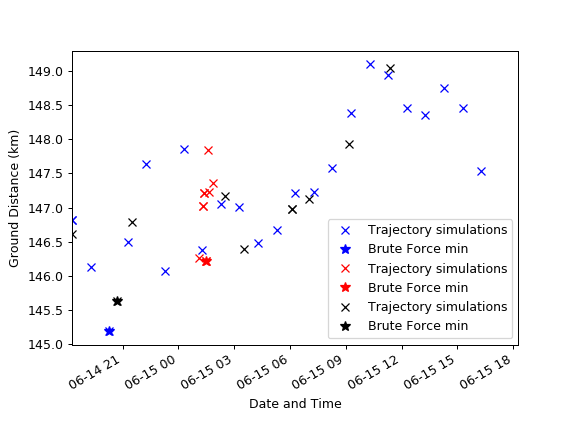

In [19]:
# fig1, ax1 = simulator.plotPaths3D()

# fig2, ax2 = simulator.plotLandingSites()
simulator.results = results_bf
simulator.bestProfile = bestProfile_bf
fig3, ax3 = simulator.plotLandingSiteDistances()

In [18]:
%autoreload
import astra

In [9]:
# Optimize with Scipy:
res = simulator.optimizeTargetLandingSite(x0=[0.3*simulator.windowDuration], options={"disp": True})
bestProfile_scipy = simulator.bestProfile
results_scipy = simulator.results

7.2
7.56
6.84
7.02
7.38
7.02
7.11
7.29
7.11
7.155
7.245
7.1775
7.155
7.18875
7.18875
7.16625
7.171875
7.183125
7.1803125
7.1746875
7.1803125
7.17609375
7.17890625
7.176796875
7.178203125
7.1771484375
7.1778515625
7.17767578125
7.17732421875
7.17767578125
7.17741210938
7.17741210938
7.17758789062
7.17754394531
7.17745605469
7.17747802734
Optimization terminated successfully.
         Current function value: 146.182990
         Iterations: 15
         Function evaluations: 36


In [20]:
# Optimize with scipy differential evolution
simulator.bestProfile = bestProfile_scipy
simulator.results = results_scipy
simulator.plotLandingSiteDistances(fig3, ax3, marker='rx', bestMarker='r*')

(<matplotlib.figure.Figure at 0x7fa9ec43af28>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa9f40b8b70>)

## Scipy differential Evolution

In [21]:
res = simulator.optimizeTargetLandingSite(method='DE')
results_de = simulator.results
bestProfile_de = simulator.bestProfile

11.8419013263
3.23214912638
14.8776863507
18.6643272065
2.39590234621
0.00918989801096
8.24384306933
12.7358585374
9.24870629375
15.4830967372
5.03837728059
17.1022145265
10.9960481218
7.18624718716
6.01361629025
9.05931812083
2.94206644233
0.210624333712
5.86048208662
11.6713664569
2.51742498472
3.37841866757
1.64290913896
2.42138576845
6.48015480272
2.84450403406
3.23698863946
1.21979087335
1.71977930555
0.0566894388753
1.64290913896
1.64290914896


In [23]:
simulator.results = results_de
simulator.bestProfile = bestProfile_de
simulator.plotLandingSiteDistances(fig3, ax3, marker='kx', bestMarker='k*')

(<matplotlib.figure.Figure at 0x7fa9ec43af28>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa9f40b8b70>)

In [ ]:
import scipy.optimize

res = scipy.optimize.minimize(f_curve, x0=[0.3*simulator.windowDuration], method='Nelder-Mead',
#                               bounds=[(0.1, simulator.windowDuration-0.1)],
                             options={"disp": True})
best_time_model = simulator.start_dateTime + timedelta(hours=res.x[0])
# res.fun
ax.plot(best_time_model, res.fun, '^r', label=r'Nelder-Mead, $x_0=0.3 \times dt$')

res = scipy.optimize.minimize(f_curve, x0=[0.7*simulator.windowDuration], method='BFGS',
#                               bounds=[(0.1, simulator.windowDuration-0.1)],
                             options={"disp": True})
best_time_model = simulator.start_dateTime + timedelta(hours=res.x[0])
# res.fun
ax.plot(best_time_model, res.fun, 'or', label=r'Nelder-Mead, $x_0=0.7 \times dt$')

In [ ]:
import scipy.optimize

res = scipy.optimize.differential_evolution(f_curve,
                              bounds=[(0.1, simulator.windowDuration-0.1)],
                              polish=False)
best_time_de = simulator.start_dateTime + timedelta(hours=res.x[0])
# res.fun
ax.plot(best_time_de, res.fun, '^g', label='DE')
print(res.nit)
lgd = ax.legend(loc='upper left')
ax.set_facecolor("white")
plt.tight_layout()
fig.savefig('brute_force_comparison.png', bbox_extra_artists=(lgd,), bbox_inches='tight')


## Testing

In [ ]:
 datetimeVector = [self.start_dateTime + timedelta(hours=t)
                            for t in range(self.windowDuration)]

nozzleLiftLowerBound = 0.4
nozzleLiftUpperBound = 1.0
nozzelLift_Vector = np.linspace(nozzleLiftLowerBound, nozzleLiftUpperBound)
self.results = {}

distance_map = {}
for i, launchSiteForecast in enumerate(self.launchSiteForecasts):
    self.environment = launchSiteForecast

    for j, t in enumerate(datetimeVector):
        distance_lift_vec = np.zeros(np.length(nozzelLift_Vector))
        for k, L in enumerate(nozzelLift_Vector):
            # brute force approach
            distance = self.targetDistance(t)
            distance_lift_vec[k] = distance

        distance_map[t] = distance_Vector  